<a href="https://colab.research.google.com/github/JosiahBeynon/detect-pneumonia-xray/blob/main/Detect_Pneumonia_Using_X_Ray_Images_with_CNNs_and_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detect Pneumonia Using X-Ray Images with CNNs and Transfer Learning

In this project, I'm experimenting with CV classifiers to demonstrate the affect of varying layers, with a hypothetical aim to build an accurate pnemonia detector.

According to the [World Health Organization](https://www.who.int/health-topics/pneumonia#tab=tab_1):

> Pneumonia is a form of acute respiratory infection that is most commonly caused by viruses or bacteria. It can cause mild to life-threatening illness in people of all ages, however it is the single largest infectious cause of death in children worldwide.
>
>Pneumonia killed more than 808 000 children under the age of 5 in 2017, accounting for 15% of all deaths of children under 5 years.  People at-risk for pneumonia also include adults over the age of 65 and people with preexisting health problems.


Before I get started, let's import the necessary libraries.

In [ ]:
import os
import time
import pickle
import tarfile
import numpy as np

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers, initializers
from tensorflow.keras import layers, models, Model, Input, applications

# Preparing the Data Set

First, I need to download the dataset.

In [ ]:
# Define the file URL and local file path
file_url = 'https://dsserver-prod-resources-1.s3.amazonaws.com/cnn/xray_dataset.tar.gz'
local_file_path = 'xray_dataset.tar.gz'

# Define the expected directory or file that would exist after extraction
extracted_path = '/content/chest_xray/train/PNEUMONIA'

# Check if the file already exists
if not os.path.exists(local_file_path):
    !wget {file_url} -O {local_file_path}
else:
    print(f"File already exists at {local_file_path}")

# Check if the file has already been extracted
if not os.path.exists(extracted_path):
    if os.path.exists(local_file_path):
        with tarfile.open(local_file_path, 'r:gz') as tar:
            tar.extractall(path='./')
    else:
        print(f"Cannot extract as {local_file_path} does not exist.")
else:
    print(f"File already extracted to {extracted_path}")


File already exists at xray_dataset.tar.gz
File already extracted to /content/chest_xray/train/PNEUMONIA


Now that's downloaded and extracted, let's load the dataset. It only comes with train and test splits, so I'll create a validation set as well.

In [ ]:
# Define the image size and batch size
img_size = (256, 256)
batch_size = 32

# Define the directory paths
train_dir = 'chest_xray/train'
test_dir = 'chest_xray/test'

# Create the train_set dataset
train_set = tf.keras.utils.image_dataset_from_directory(
    directory=train_dir,
    labels='inferred',
    label_mode='binary',
    batch_size=batch_size,
    image_size=img_size,
    validation_split=0.25,
    subset="training",
    seed=417
)

# Create the validation_set dataset
validation_set = tf.keras.utils.image_dataset_from_directory(
    directory=train_dir,
    labels='inferred',
    label_mode='binary',
    batch_size=batch_size,
    image_size=img_size,
    validation_split=0.25,
    subset="validation",
    seed=417
)

# Create the test_set dataset
test_set = tf.keras.utils.image_dataset_from_directory(
    directory=test_dir,
    labels='inferred',
    label_mode='binary',
    batch_size=batch_size,
    image_size=img_size
)


Found 5232 files belonging to 2 classes.
Using 3924 files for training.
Found 5232 files belonging to 2 classes.
Using 1308 files for validation.
Found 624 files belonging to 2 classes.


Let's check our labels have come out as expected.

In [ ]:
train_set.class_names

['NORMAL', 'PNEUMONIA']

Class labels look good, and are obviously named.

Next, I'll plot comparative images from the dataset to get an idea what we're classifying.

## Plotting X-Ray Images

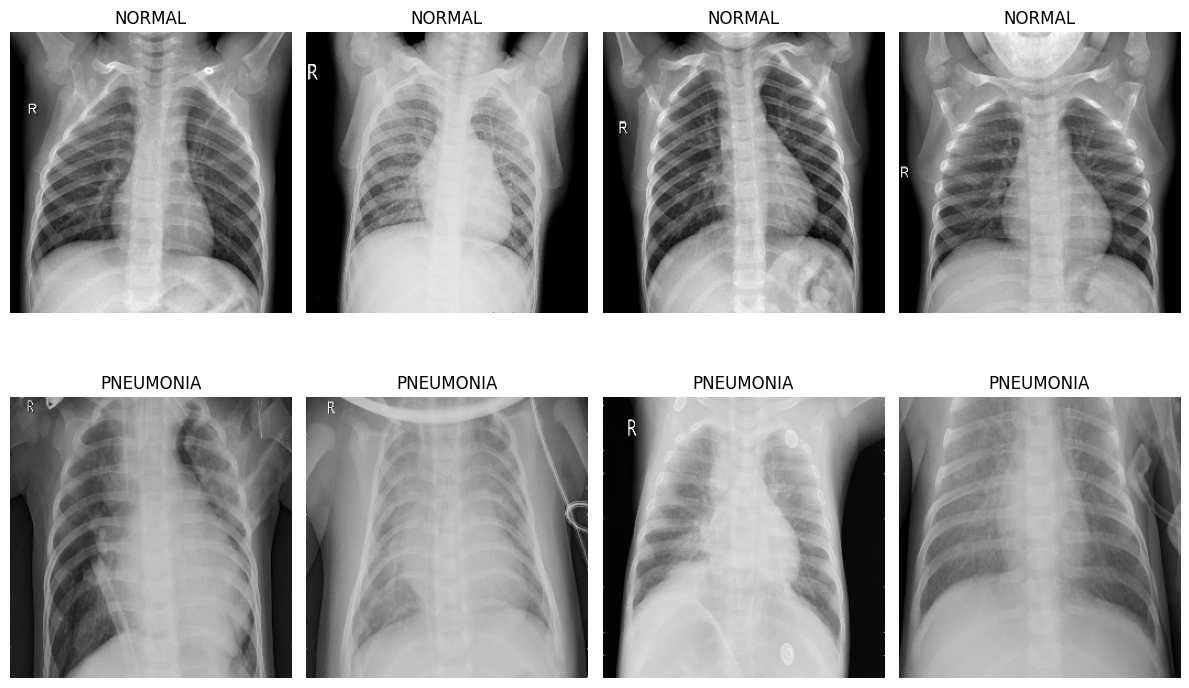


Each image shape is (256, 256, 3)


In [ ]:
# Retrieve the images and labels from train_set.take(1)
images, labels = next(iter(train_set.take(1)))

# Convert the images and labels to NumPy arrays
images = images.numpy()
labels = labels.numpy()

# Sort the image-label pairs based on the label (ascending order)
sorted_pairs = sorted(zip(images, labels), key=lambda x: x[1])

# Select a sample of images with both normal and pneumonia labels
sample = sorted_pairs[:4] + sorted_pairs[-4:]

# Plot the sorted images with their corresponding labels
fig, axes = plt.subplots(2, 4, figsize=(12, 8))
axes = axes.flatten()

# Format the plot
for i, (image, label) in enumerate(sample):
    axes[i].imshow(image.astype("uint8"))
    axes[i].set_title(train_set.class_names[int(label)])
    axes[i].axis("off")
plt.tight_layout()

# Display the plot
plt.show()
print(f'\nEach image shape is {sample[0][0].shape}')

In [ ]:
# Removes no longer needed variables
del images, labels, sorted_pairs, sample

Would you have guessed those labels from the X-rays? I have no radiography training and find it hard to tell the difference in many cases. The pneumonia X-rays seem to be 'cloudier' than the normal X-rays. But I wouldn't want to be the one diagnosing.

A few things to note:
* The images have 3 channels, despite seeming to be grayscale.
* All X-rays have the right side of the patient (the white 'R' on the image) on the LEFT side of the image. This appears to be consistent across the data set. Given that humans aren't perfectly symmetrical (e.g. our heart is on our left side), we'll not flip any images horizontally. This will preserve the 'sidedness' of the X-rays in case that affects the diagnosis.
* There's a small amount of rotation in the X-rays. Presumably, this is incurred when they take them. We could profit from this by adding rotational augmentation to our training set, which will increase variance without losing 'sidedness'.
* All X--rays picture the same anotomical area. Therefore augmentation tools like `RandomZoom` are unlikely to helpful.
* Brightness and contrast also seem to be stable across the X-rays. Therefore we'll not bother with `RandomBrightness` or `RandomContrast`.

Judging by the similarities between the images, we'll may not get good results with a simple CNN. We'll have a go anyway, and use that as our benchmark.

# Model Building

Before I begin, I'll define a range of helper functions we'll use throughout our modelling.

## Helper Functions

These functions handle the majority of the heavy lifting, allowing me to run and compare models with only a couple lines of code.

# Remove model name as arg if no longer needed

In [ ]:
def plot_history(history):
    '''
    Plots the training and validation accuracy and loss for each epoch.

    Parameters:
        history (dict): Dictionary containing training history.
    '''

    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    for metric, ax in zip(['accuracy', 'loss'], axs):
      epochs = len(history[metric]) + 1
      ax.plot(np.arange(1, epochs), # Corrects epoch number
                        history[metric])
      ax.plot(np.arange(1, epochs), # Corrects epoch number
                        history['val_' + metric])
      ax.set_title('Model ' + metric.capitalize())
      ax.set_ylabel(metric.capitalize())
      ax.set_xlabel('Epoch')
      ax.legend(['Train', 'Validation'], loc='upper left')
      ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

    plt.tight_layout()
    plt.show()

# Defines EarlyStopping callback we'll use throughout our modelling
callback = tf.keras.callbacks.EarlyStopping(
monitor='val_accuracy',
patience=3,
verbose=1,
mode='max',
restore_best_weights=True
)

# Initializes the metrics list
model_info = []
model_list = []

def fit_plot_store(model, epochs=10, shuffle=False,
                   batch_size=32, overwrite=False):
    """
    Fit, plot, and store model data, managing existing data when applicable.

    Parameters:
        model (tf.keras.Model): The model to be trained and managed.
        epochs (int, optional): The number of training epochs (default is 10).
        shuffle (bool, optional): Whether to shuffle the training data (default is False).
        batch_size (int, optional): The batch size for training (default is 32).
        overwrite (bool, optional): Whether to overwrite existing model and history data (default is False).

    This function trains the given model, manages model and training history data,
    and updates or stores model metrics and history in an organized manner.

    If `overwrite` is False and existing data for the model is found, it will load the
    existing model and history, preserving previously trained information.

    If `overwrite` is True or no existing data is found, it will train the model from scratch,
    plot the training history, save the model, and store the metrics for reference.

    Returns:
        None
    """
    # Define file name, dirs, and paths
    model_name = model.name
    directories = ['models', 'history']
    model_file = f'models/{model_name}.h5'
    history_file = f'history/{model_name}_history.pkl'

    # Check for existing files
    if (os.path.exists(model_file) and
        os.path.exists(history_file) and
        not overwrite):
        # Load existing model and history
        model = tf.keras.models.load_model(model_file)
        with open(history_file, 'rb') as file:
            history = pickle.load(file)
        print(f'Loaded model and history for {model_name}')
    else:
        # Train the model
        history = model.fit(train_set,
                            epochs=epochs,
                            validation_data=validation_set,
                            shuffle=shuffle,
                            batch_size=batch_size,
                            callbacks=[callback]
                            ).history

        # Makes dirs if needed
        for dir in directories:
          os.makedirs(dir, exist_ok=True)

        # Saves model and history
        model.save(model_file)
        with open(history_file, 'wb') as file:
            pickle.dump(history, file)

    # Plot the history
    plot_history(history)

    # Storing or updating the metrics
    training_accuracy = history['accuracy'][-1]
    val_accuracy = history['val_accuracy'][-1]
    training_loss = history['loss'][-1]
    val_loss = history['val_loss'][-1]
    trainable_params = np.sum([K.count_params(w) for w in model.trainable_weights])
    non_trainable_params = np.sum([K.count_params(w) for w in model.non_trainable_weights])
    num_epochs = len(history['accuracy'])
    total_params = trainable_params + non_trainable_params

    # Update or store model metrics
    model_info.append([model_name, training_accuracy, val_accuracy,
                       training_loss, val_loss, trainable_params,
                       non_trainable_params, total_params,
                       num_epochs]
                      )

    # Append the model to the model list
    model_list.append(model)


## Initial CNN - Model 1

I'll start with a fairly small model. We'll use a normalization layer (to rescale the pixel values between 0 and 1), one convolutional layer, one max pooling, and two dense layers.

In [ ]:
model_1 = models.Sequential([
    layers.Rescaling(1./255, input_shape=(img_size[0], img_size[1], 3)),
    layers.Conv2D(8, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='sigmoid')
    ],
    name='Model_1'
    )

model_1.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
    )

model_1.summary()

Model: "Model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 8)       0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 8)                 1048584   
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                           

Our simple model still has over a million parameters. Though these are almost all in the dense layers. Let's see how our model performs, though I'm not expecting much.

I'll also define a couple helper functions that we'll use throughout our comparisons.

Loaded model and history for Model_1


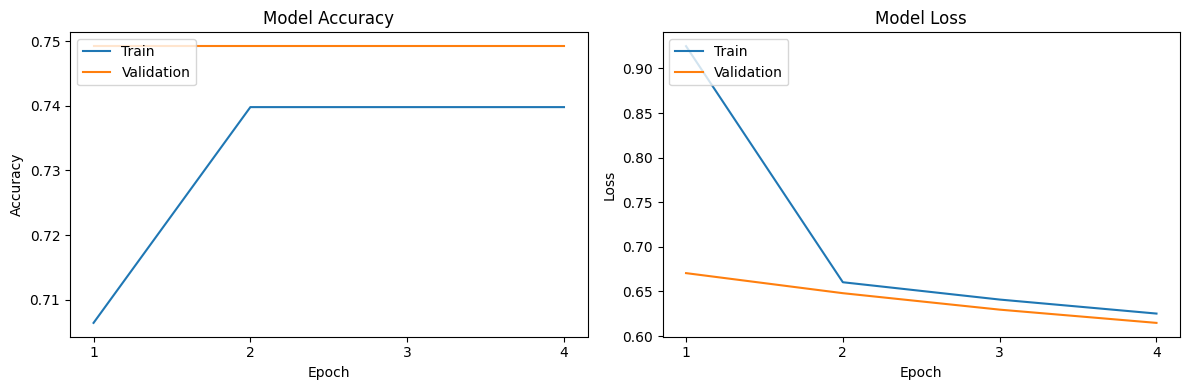

In [ ]:
fit_plot_store(model_1)

Our simple model achieved a reasonable 75% accuracy. That's far better than random, yet we wouldn't want to be diagnosed by it yet.

Let's add a few more layers.

## Model 2

We'll add another convolutional layer, a max pooling layer, and a dense layer.

In [ ]:
model_2 = models.Sequential([
    layers.Rescaling(1./255, input_shape=(img_size[0], img_size[1], 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(8, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='sigmoid')
    ],
    name='Model_2'
    )

model_2.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
    )

model_2.summary()

Model: "Model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 128, 128, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 8)       1160      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 64, 64, 8)         0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0   

We've added two layers and **reduced** the number of parameters by 4X. This is due to our max pooling layers regularizing affect. Let's see how our new model performs.

Loaded model and history for Model_2


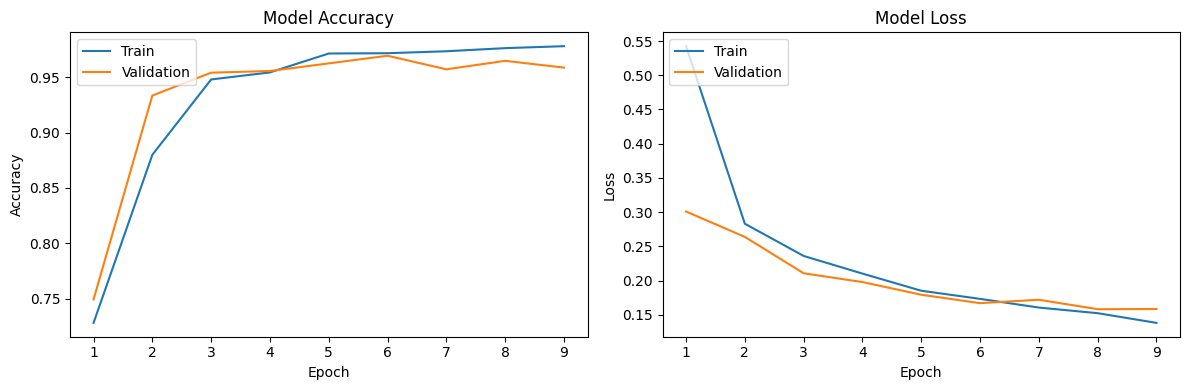

In [ ]:
fit_plot_store(model_2)

Our accuracy has improved significantly to around 96% accuracy.

The model may be beginnining to overfit. Certainly accuracy is starting to level off.

Since we're more interested in comparing general architectures, I'll move on for now and experiment with augmentation.



# Model 3

We're going to try two approaches:
* Rotation - Adding up to 15 degrees of random rotation to some images
* Shuffle - This shuffles the order of the images, stopping the model just learning the order

In [ ]:
model_3 = models.Sequential([
    layers.Rescaling(1./255, input_shape=(img_size[0], img_size[1], 3)),
    layers.RandomRotation(15),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(8, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='sigmoid')
    ],
    name='Model_3'
    )

model_3.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
    )

model_3.summary()

Model: "Model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 random_rotation (RandomRot  (None, 256, 256, 3)       0         
 ation)                                                          
                                                                 
 conv2d_3 (Conv2D)           (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 128, 128, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 8)       1160      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 64, 64, 8)         0   

Loaded model and history for Model_3


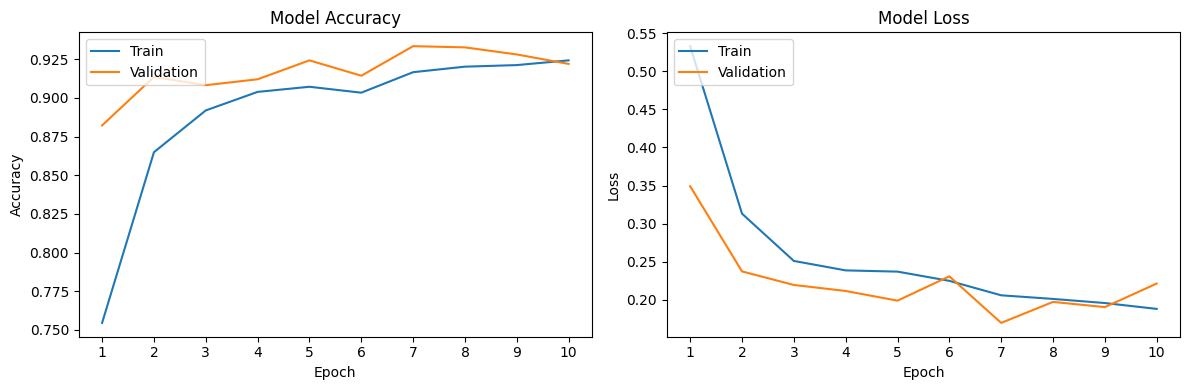

In [ ]:
fit_plot_store(model_3, epochs=20, shuffle=True)

Adding shuffle and rotate didn't help. In fact. it reduced the accuracy.

It seems our simple model wasn't able to cope with the added complexity, so lets try a more complex model.

## Model 4

In [ ]:
model_4 = models.Sequential([
    layers.Rescaling(1./255, input_shape=(img_size[0], img_size[1], 3)),
    layers.RandomRotation(15),
    layers.Conv2D(32, 5, padding='same', activation='relu'),
    layers.Conv2D(32, 5, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='sigmoid')
    ],
    name='Model_4'
    )

model_4.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
    )

model_4.summary()

Model: "Model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 random_rotation_1 (RandomR  (None, 256, 256, 3)       0         
 otation)                                                        
                                                                 
 conv2d_5 (Conv2D)           (None, 256, 256, 32)      2432      
                                                                 
 conv2d_6 (Conv2D)           (None, 256, 256, 32)      25632     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 128, 128, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 128, 128, 16)      4624

We'e

Loaded model and history for Model_4


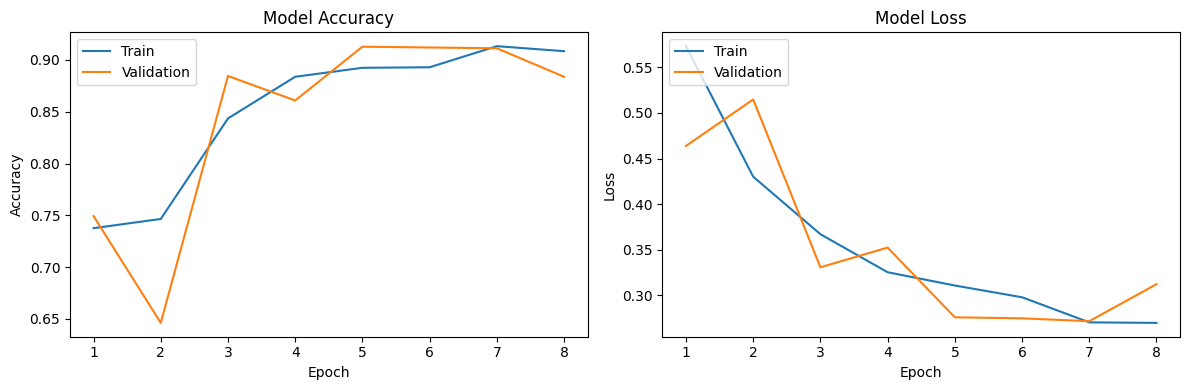

In [ ]:
fit_plot_store(model_4, epochs=20, shuffle=True)

This performed better than model 3, and is still lagging behind model 2.

As you can see above, the process of tuning a model is long and experimental. We could keep tweaking models. However, in many cases it's faster to finetune an appropriate pretrained model.

# Using Pretrained Models

I'm going to use a variant of ResNet, a model that was trained on the [ImageNet](https://www.image-net.org/) dataset.

## ResNet50

This is the smallest of the pretrained ResNet models available directly through Keras. The model was pretrained to classify 1000 classes, none of which where pneumonia on chest X-rays. Therefore, it'll probably benefit from some fine tuning on the CNN layers.

However, let's see how it does out the box.

## First ResNet50 Model
I have to add and train a single dense layer at the end. This is because we want to use it for binary classification instead of it's original use. I'll freeze the entire ResNet50 model and just update our single node dense layer.

In [ ]:
# Build a ResNes 50 model and evaluate it
resnet50_base = applications.ResNet50(
    weights='imagenet',
    include_top=False,
    pooling='max',
    input_shape=(img_size[0], img_size[1], 3)
)

# Freeze the ResNet50 model
resnet50_base.trainable = False

# Add a dense layer
resnet50 = models.Sequential([
    resnet50_base,
    layers.Dense(1, activation='sigmoid')
    ],
    name='ResNet50'
    )


# Compile the model
resnet50.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

resnet50.summary()

Model: "ResNet50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_8 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 23589761 (89.99 MB)
Trainable params: 2049 (8.00 KB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


Note that for our 23.5 million parameter model, we're only training 2,049 parameters.

Before we fit our model, I need to preprocess the image. ResNet50 has strict expectations of the images. As the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/preprocess_input) explains:
> The images are converted from RGB to BGR, then each color channel is zero-centered with respect to the ImageNet dataset, without scaling.


Loaded model and history for ResNet50


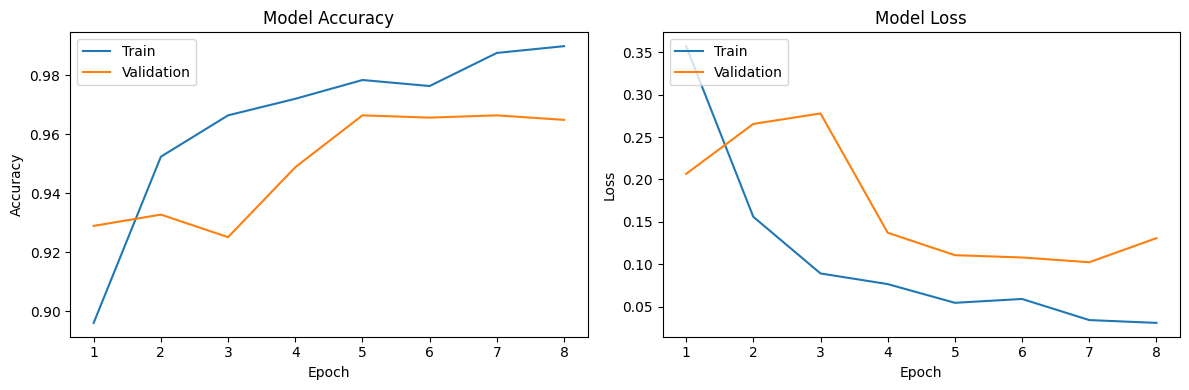

In [ ]:
# Define the preprocessing function
def preprocess_image(image, label):
    image = applications.resnet.preprocess_input(image)
    return image, label

# Apply necessary preprocessing using tf.data.Dataset.map()
resnet_train = train_set.map(preprocess_image)
resnet_val = validation_set.map(preprocess_image)
resnet_test = test_set.map(preprocess_image)

# Train the model
fit_plot_store(resnet50, epochs=20)

Our accuracy is high at 96% for the validation set. We're also showing clear signs of overfitting.

I could tweak the CNN layers. However, since the accuracy is already very high, I'll just add another dense layer at the end and see if that helps.

## Second ResNet50 Model

In [ ]:
# Add a dense layer and dropout
resnet50_2 = models.Sequential([
    resnet50_base,
    layers.Dense(8, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
    ],
    name='ResNet50_2'
    )

# Compile the model
resnet50_2.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

resnet50_2.summary()

Model: "ResNet50_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_9 (Dense)             (None, 8)                 16392     
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_10 (Dense)            (None, 1)                 9         
                                                                 
Total params: 23604113 (90.04 MB)
Trainable params: 16401 (64.07 KB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


Loaded model and history for ResNet50_2


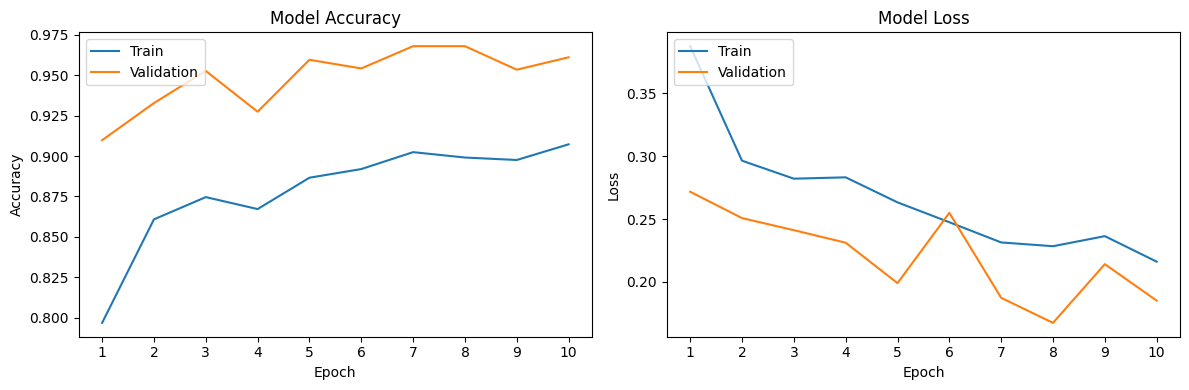

In [ ]:
fit_plot_store(resnet50_2, epochs=20, shuffle=True)


# Rewrite
Definitely overfitting! Though our `EarlyStopping` callback caught this and stopped the training. The model's been reverted back to it's best epoch, which had an accuracy of 97.6%.

## Third ResNet50 Model

# Rewrite
Since our last model was overfitting, it's unlikely that increasing complexity will help. However, for demostration, let's try adding another dense layer.

In [ ]:
# Adding a dense layer, more dropout and regularization
resnet50_3 = models.Sequential([
    resnet50_base,
    layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)),
    layers.Dropout(0.3),
    layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
    ],
    name='ResNet50_3'
    )

# Compile the model
resnet50_3.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

resnet50_3.summary()

Model: "ResNet50_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_11 (Dense)            (None, 16)                32784     
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_12 (Dense)            (None, 8)                 136       
                                                                 
 dropout_2 (Dropout)         (None, 8)                 0         
                                                                 
 dense_13 (Dense)            (None, 1)                 9         
                                                                 
Total params: 23620641 (90.11 MB)
Trainable params: 3292

Loaded model and history for ResNet50_3


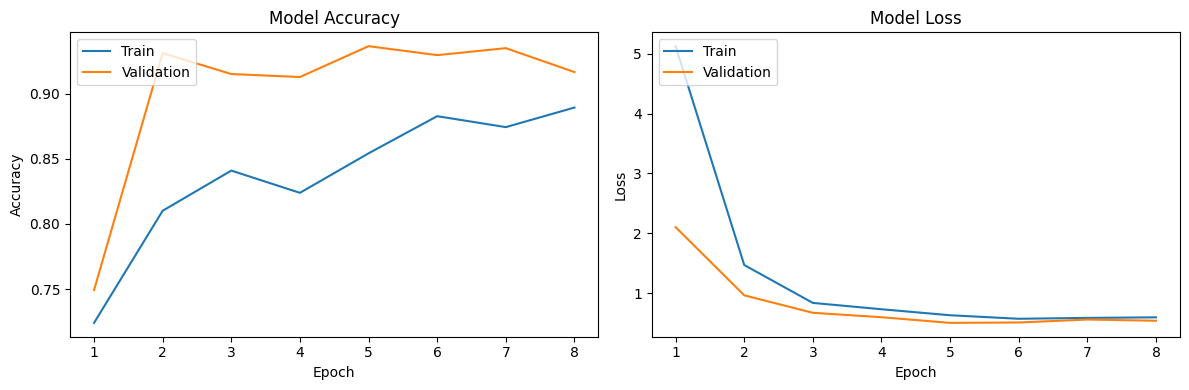

In [ ]:
fit_plot_store(resnet50_3, epochs=20, shuffle=True)

# Displaying Results

In [ ]:
column_names = ['Model Name', 'Training Accuracy', 'Validation Accuracy',
                'Training Loss', 'Validation Loss', 'Trainable Parameters',
                'Non-trainable Parameters', 'Total Parameters',
                'Number of Epochs']


# Changes the list to a DataFrame
model_info_df = pd.DataFrame(model_info, columns=column_names)
model_info_df.set_index('Model Name', inplace=True)

# Sort the DataFrame by Model Name
model_info_df.sort_values('Model Name', inplace=True)
model_info_df

,Training Accuracy,Validation Accuracy,Training Loss,Validation Loss,Trainable Parameters,Non-trainable Parameters,Total Parameters,Number of Epochs
Model Name,,,,,,,,
Model_1,0.739806,0.749235,0.625252,0.614812,1048817,0.0,1048817.0,4
Model_2,0.978084,0.958716,0.138194,0.158459,263769,0.0,263769.0,9
Model_3,0.924312,0.922018,0.188303,0.221521,263769,0.0,263769.0,10
Model_4,0.908512,0.883792,0.269465,0.311955,556993,0.0,556993.0,8
ResNet50,0.989806,0.964832,0.030718,0.130725,2049,23587712.0,23589761.0,8
ResNet50_2,0.907238,0.961009,0.216096,0.185086,16401,23587712.0,23604113.0,10
ResNet50_3,0.889399,0.916667,0.593275,0.536222,32929,23587712.0,23620641.0,8


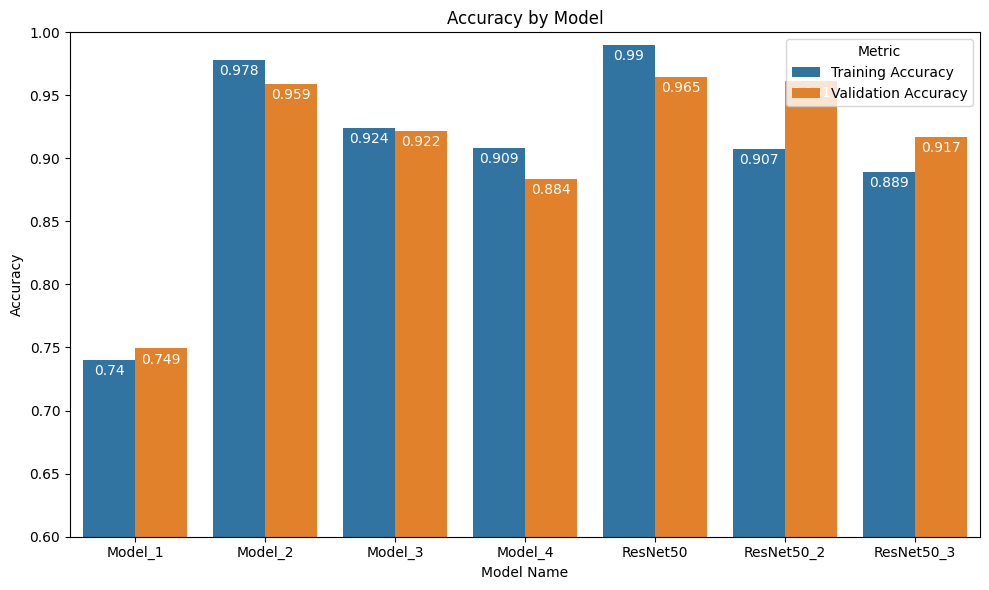

In [ ]:
def plot_accuracy(df, vars, subtitle=''):
    '''Plots the training, validation, and test accuracy for each model in df'''
    # Reshape the data from wide to long format
    melted_df = df.reset_index().melt(id_vars='Model Name',
                                      value_vars=vars,
                                      var_name='Metric',
                                      value_name='Accuracy')

    # Plot the vertical bar chart using Seaborn
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x='Model Name', y='Accuracy',
                     hue='Metric', data=melted_df, errorbar=None)


    # Set the title and axis labels
    plt.title('Accuracy by Model' + subtitle)
    plt.xlabel('Model Name')
    plt.ylabel('Accuracy')
    plt.ylim(0.6, 1)
    plt.tight_layout()

    # Add value labels to the bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%.3g', label_type='edge',
                     padding=-13, color='white'
                     )

    # Display the plot
    plt.show()

# Usage
plot_accuracy(model_info_df,
              ['Training Accuracy', 'Validation Accuracy']
              )

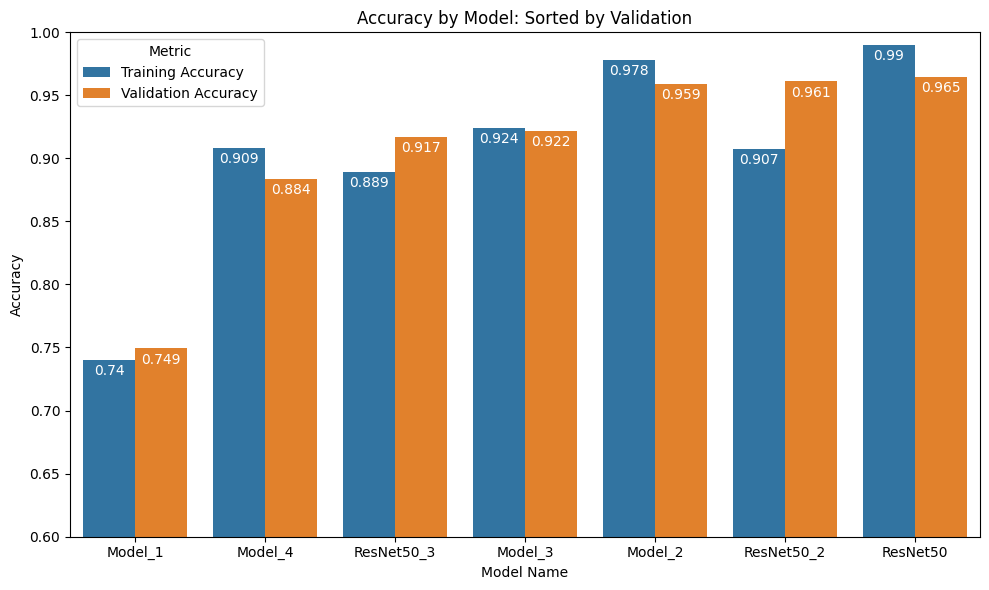

In [ ]:
# Sort the DataFrame by test accuracy
by_val = model_info_df.sort_values('Validation Accuracy')
plot_accuracy(by_val,
              ['Training Accuracy', 'Validation Accuracy'],
              subtitle=': Sorted by Validation'
              )

# Assessing Real World Performance

With all models trained and validated, it's time to test them on unseen data. I'v kept the test data seperate until this point to avoid any leakage. I'll test all models and graph the results.

Which do you think is likely to do best?

In [ ]:
test_accuracy = []
test_loss = []

for model in model_list:
    # Evaluate the model on the test set
    print(model.name)
    loss, accuracy = model.evaluate(test_set)
    test_accuracy.append(accuracy)
    test_loss.append(loss)

model_info_df['Test Accuracy'] = test_accuracy
model_info_df['Test Loss'] = test_loss

filtered_columns =  ['Training Accuracy', 'Validation Accuracy', 'Test Accuracy']
model_info_df.loc[:, filtered_columns]

Model_1
20/20 [==============================] - 5s 99ms/step - loss: 0.6824 - accuracy: 0.6250
Model_2
20/20 [==============================] - 4s 102ms/step - loss: 0.9224 - accuracy: 0.7692
Model_3
20/20 [==============================] - 5s 158ms/step - loss: 0.5502 - accuracy: 0.7708
Model_4
20/20 [==============================] - 7s 173ms/step - loss: 0.4846 - accuracy: 0.8157
ResNet50
20/20 [==============================] - 9s 220ms/step - loss: 1.0692 - accuracy: 0.7788
ResNet50_2
20/20 [==============================] - 7s 152ms/step - loss: 0.8592 - accuracy: 0.8221
ResNet50_3
20/20 [==============================] - 7s 147ms/step - loss: 0.8144 - accuracy: 0.8045


,Training Accuracy,Validation Accuracy,Test Accuracy
Model Name,,,
Model_1,0.739806,0.749235,0.625000
Model_2,0.978084,0.958716,0.769231
Model_3,0.924312,0.922018,0.770833
Model_4,0.908512,0.883792,0.815705
ResNet50,0.989806,0.964832,0.778846
ResNet50_2,0.907238,0.961009,0.822115
ResNet50_3,0.889399,0.916667,0.804487


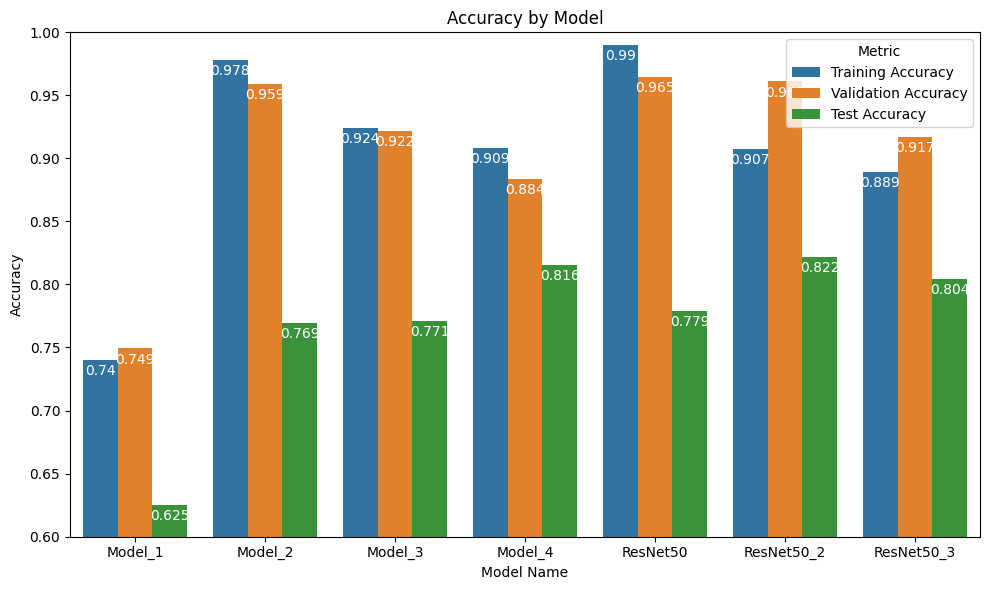

In [ ]:
# Usage
plot_accuracy(model_info_df,
              ['Training Accuracy', 'Validation Accuracy', 'Test Accuracy']
              )

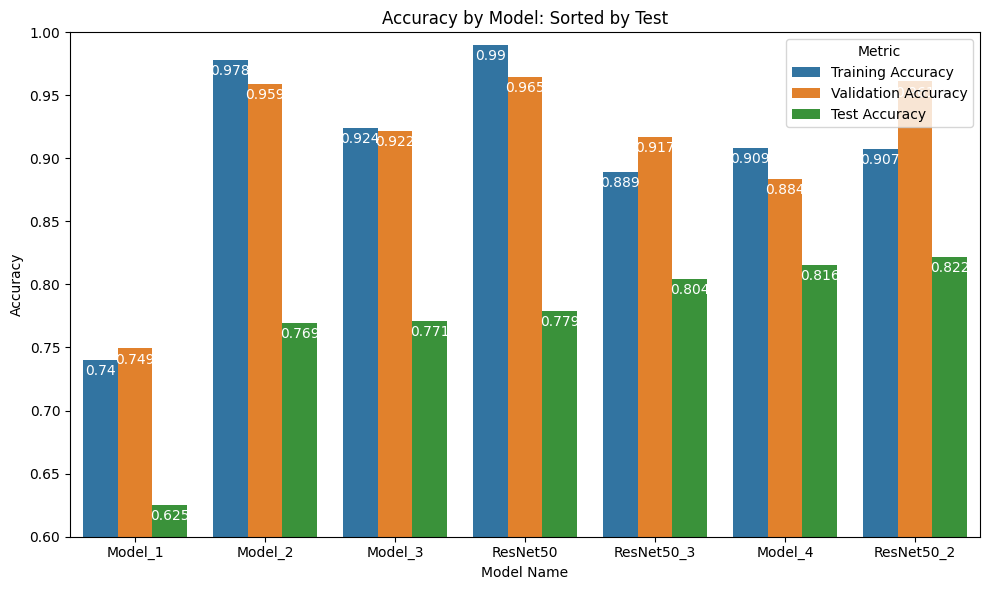

In [ ]:
# Sort the DataFrame by test accuracy
by_val = model_info_df.sort_values('Test Accuracy')
plot_accuracy(by_val,
              ['Training Accuracy', 'Validation Accuracy', 'Test Accuracy'],
              subtitle=': Sorted by Test'
              )

# Exporting Model Files

Finally, before downloading/exporting the model files, I need to zip them.



In [ ]:
# Uncomment if needed
# from google.colab import files
# directories = ['models', 'history']
# for dir in directories:
#     !zip -r /content/{dir}.zip /content/{dir}
#     files.download(f'{dir}.zip')

# Improving the project

Areas I could improve this project are:
* Rewriting `fit_plot_store` to include a way to run more epochs on a current model.
* Spend more time tuning the models to improve accuracy
* Compare multiple pretrained models instead of just `ResNet50`

